In [1]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as  pd
from matplotlib.patches import Rectangle
import os 

In [2]:
# loading climatologies

prism = xr.open_dataset('/home/sbeale/climatologies/tmax_03_PRISM.nc')
wrf = xr.open_dataset('/home/sbeale/climatologies/tmax_03_WRF_coarse.nc')
coast = xr.open_dataset('/home/sbeale/climatologies/coast.nc')
dem = xr.open_dataset('/home/sbeale/climatologies/DEM.nc')
lat = xr.open_dataset('/home/sbeale/climatologies/lat.nc')
lon = xr.open_dataset('/home/sbeale/climatologies/lon.nc')


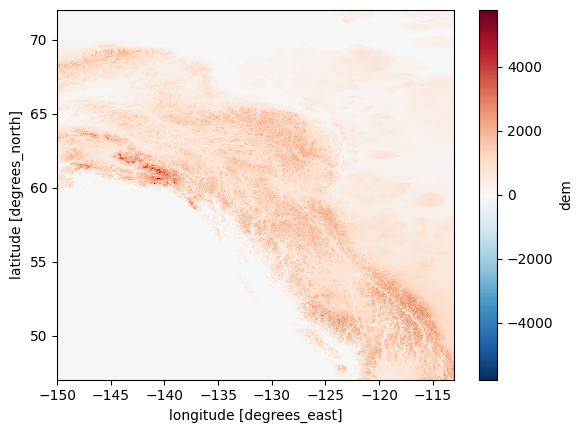

In [3]:
dem.dem.plot()

In [4]:
wrf

<xarray.Dataset> Size: 3MB
Dimensions:    (longitude: 1109, latitude: 749)
Coordinates:
  * longitude  (longitude) float64 9kB -150.0 -150.0 -149.9 ... -113.1 -113.1
  * latitude   (latitude) float64 6kB 71.99 71.95 71.92 ... 47.12 47.09 47.05
Data variables:
    tmax       (latitude, longitude) float32 3MB ...
    crs        int32 4B ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-78)
    date:         2024-06-17 13:21:34

In [5]:
# removing alaska
min_lon = -150
max_lon = -140.2
min_lat = 59
max_lat = 71

# replacing cropped values with NaN
prism['tmax'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN
wrf['tmax'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN

coast['dist'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN
dem['dem'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN
lat['lat'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN
lon['lon'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN

Text(0.5, 0.01, 'longitude [deg E]')

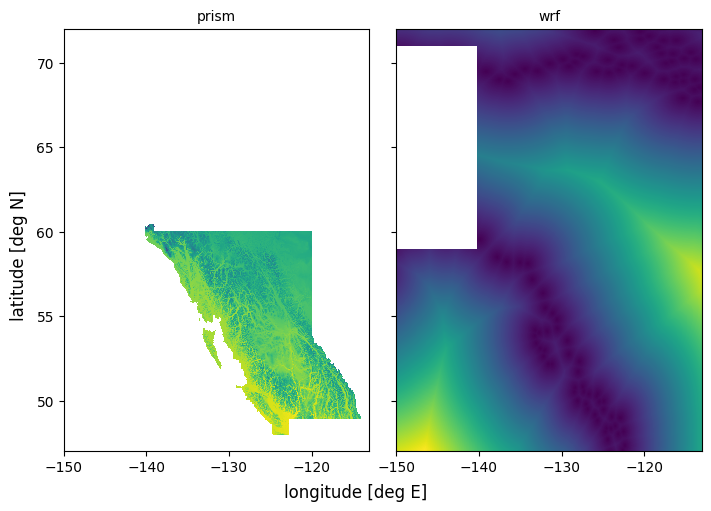

In [6]:
fig, ax = plt.subplots(1, 2, layout='constrained', figsize=(7, 5), sharex=True, sharey=True)

pc1 = ax[0].pcolormesh(prism.longitude, prism.latitude, prism.tmax, cmap='viridis', label=r'$m$')
ax[0].set_title(f'prism', fontsize='medium', loc='center')

pc1 = ax[1].pcolormesh(coast.longitude, coast.latitude, coast.dist, cmap='viridis', label=r'$m$')
ax[1].set_title(f'wrf', fontsize='medium', loc='center')

fig.supylabel('latitude [deg N]')
fig.supxlabel('longitude [deg E]')

In [7]:
prism_tmax = prism['tmax']
wrf_tmax = wrf['tmax']
coast_dist = coast['dist']
dem_dem = dem['dem']
lat_lat = lat['lat']
lon_lon = lon['lon']

In [8]:
# calculating mean 

prism_mean = np.nanmean(prism['tmax'])
wrf_mean = np.nanmean(wrf['tmax'])
coast_mean = np.nanmean(coast['dist'])
dem_mean = np.nanmean(dem['dem'])
lat_mean = np.nanmean(lat['lat'])
lon_mean = np.nanmean(lon['lon'])

In [9]:
# calculating standard deviation 

prism_std = np.nanstd(prism['tmax'])
wrf_std = np.nanstd(wrf['tmax'])
coast_std = np.nanstd(coast['dist'])
dem_std = np.nanstd(dem['dem'])
lat_std = np.nanstd(lat['lat'])
lon_std = np.nanstd(lon['lon'])

In [21]:
print(prism_std, prism_mean)

3.899911 1.6630528


In [22]:
import csv 

# data rows as dictionary objects 
mydict =[{'var': 'tmax', 'month':3, 'clim': 'prism', 'mean': prism_mean, 'std':prism_std}, 
         {'var': 'tmax', 'month':3, 'clim': 'wrf', 'mean': wrf_mean, 'std':wrf_std}, 
         {'var': 'dist from coast', 'month':3, 'clim': 'prism', 'mean':coast_mean, 'std':coast_std},
         {'var': 'dem', 'month':3, 'clim': 'prism', 'mean':dem_mean, 'std':dem_std},
         {'var': 'lat', 'month':3, 'clim': 'prism', 'mean':lat_mean, 'std':lat_std},
         {'var': 'lon', 'month':3, 'clim': 'prism', 'mean':lon_mean, 'std':lon_std},
         ]

# field names 
fields = ['var','month', 'clim', 'mean', 'std'] 

with open('/home/sbeale/tmax_march_pt_BC/standardization.csv', 'w', newline='') as file: 
    writer = csv.DictWriter(file, fieldnames = fields)

    writer.writeheader() 

    writer.writerows(mydict)

In [10]:
# standardizing all variables 
prism['tmax'] = (prism_tmax - prism_mean)/prism_std
wrf['tmax'] = (wrf_tmax - wrf_mean)/wrf_std
coast['dist'] = (coast_dist - coast_mean)/coast_std
dem['dem'] = (dem_dem - dem_mean)/dem_std
lat['lat'] = (lat_lat - lat_mean)/lat_std
lon['lon'] = (lon_lon - lon_mean)/lon_std

In [11]:
# selecting slice of upper BC for testing data
min_lon = -128
max_lon = -119
min_lat = 56
max_lat = 61
prism_test = prism.where((prism.latitude <= max_lat) & (prism.latitude >= min_lat) & (prism.longitude >= min_lon) & (prism.longitude <= max_lon), drop=True)
wrf_test = wrf.where((wrf.latitude <= max_lat) & (wrf.latitude >= min_lat) & (wrf.longitude >= min_lon) & (wrf.longitude <= max_lon), drop=True)

coast_test = coast.where((coast.latitude <= max_lat) & (coast.latitude >= min_lat) & (coast.longitude >= min_lon) & (coast.longitude <= max_lon), drop=True)
dem_test = dem.where((dem.latitude <= max_lat) & (dem.latitude >= min_lat) & (dem.longitude >= min_lon) & (dem.longitude <= max_lon), drop=True)
lat_test = lat.where((lat.latitude <= max_lat) & (lat.latitude >= min_lat) & (lat.longitude >= min_lon) & (lat.longitude <= max_lon), drop=True)
lon_test = lon.where((lon.latitude <= max_lat) & (lon.latitude >= min_lat) & (lon.longitude >= min_lon) & (lon.longitude <= max_lon), drop=True)

In [15]:
wrf.to_netcdf('/home/sbeale/random_for/wrf_train.nc')
dem.to_netcdf('/home/sbeale/random_for/dem_train.nc')
lat.to_netcdf('/home/sbeale/random_for/lat_train.nc')
lon.to_netcdf('/home/sbeale/random_for/lon_train.nc')
coast.to_netcdf('/home/sbeale/random_for/coast_train.nc')

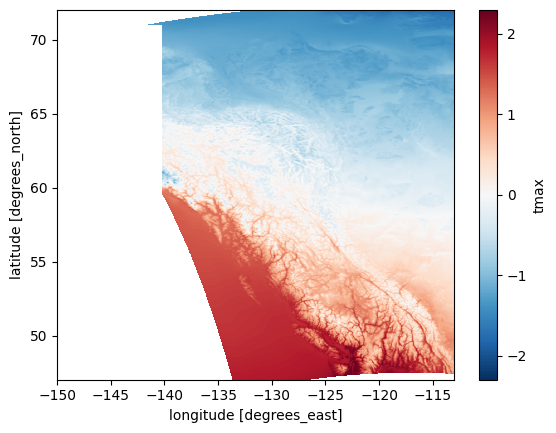

In [45]:
x = xr.open_dataset('/home/sbeale/random_for/wrf_train.nc')
x.tmax.plot()

In [12]:
# replacing cropped values with NaN
prism['tmax'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN
wrf['tmax'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN

coast['dist'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN
dem['dem'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN
lat['lat'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN
lon['lon'].loc[dict(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))] = np.NaN

In [13]:
wrf_test

<xarray.Dataset> Size: 489kB
Dimensions:    (latitude: 150, longitude: 270)
Coordinates:
  * longitude  (longitude) float64 2kB -128.0 -128.0 -127.9 ... -119.1 -119.0
  * latitude   (latitude) float64 1kB 60.99 60.95 60.92 ... 56.09 56.05 56.02
Data variables:
    tmax       (latitude, longitude) float32 162kB -0.3738 -0.3084 ... 0.2503
    crs        (latitude, longitude) float64 324kB -2.147e+09 ... -2.147e+09
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-78)
    date:         2024-06-17 13:21:34

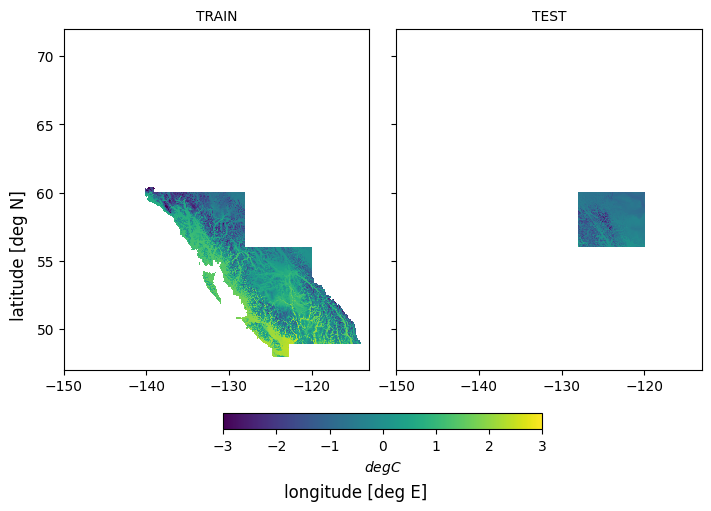

In [14]:
fig, ax = plt.subplots(1, 2, layout='constrained', figsize=(7, 5), sharex=True, sharey=True)

pc1 = ax[0].pcolormesh(prism.longitude, prism.latitude, prism.tmax, cmap='viridis', vmin=-3, vmax=3, label=r'$m$')
ax[0].set_title(f'TRAIN', fontsize='medium', loc='center')

pc1 = ax[1].pcolormesh(prism_test.longitude, prism_test.latitude, prism_test.tmax, cmap='viridis', vmin=-3, vmax=3, label=r'$m$')
ax[1].set_title(f'TEST', fontsize='medium', loc='center')

fig.supylabel('latitude [deg N]')
fig.supxlabel('longitude [deg E]')

fig.colorbar(pc1, shrink=0.5, aspect=20, location='bottom', ax=ax[0:2], label=r'$deg C$')

In [28]:
prism.to_netcdf('/home/sbeale/random_for/prism_train.nc')

In [15]:
prism_pt = np.array(prism.tmax)
wrf_pt = np.array(wrf.tmax)
coast_pt = np.array(coast.dist)
dem_pt = np.array(dem.dem)
lat_pt = np.array(lat.lat)
lon_pt = np.array(lon.lon)

In [16]:
prism_test_pt = np.array(prism_test.tmax)
wrf_test_pt = np.array(wrf_test.tmax)
coast_test_pt = np.array(coast_test.dist)
dem_test_pt = np.array(dem_test.dem)
lat_test_pt = np.array(lat_test.lat)
lon_test_pt = np.array(lon_test.lon)

In [17]:
x_fine = np.arange(0,prism_pt.shape[0]-128, 8)
y_fine = np.arange(0,prism_pt.shape[1]-128, 8)

x_coarse = np.arange(0,wrf_pt.shape[0]-32, 2)
y_coarse = np.arange(0,wrf_pt.shape[1]-32, 2)

In [18]:
x_fine_test= np.arange(0,prism_test_pt.shape[0]-128, 8)
y_fine_test = np.arange(0,prism_test_pt.shape[1]-128, 8)

x_coarse_test = np.arange(0,wrf_test_pt.shape[0]-32, 2)
y_coarse_test = np.arange(0,wrf_test_pt.shape[1]-32, 2)

In [19]:
tiles_fine_prism = []
tiles_fine_coast = []
tiles_fine_dem = []
tiles_fine_lat = []
tiles_fine_lon = []
for i in range(0, len(y_fine)):
    prism = prism_pt[:,0+y_fine[i]:128+y_fine[i]]
    coast = coast_pt[:,0+y_fine[i]:128+y_fine[i]]
    dem = dem_pt[:,0+y_fine[i]:128+y_fine[i]]
    lat = lat_pt[:,0+y_fine[i]:128+y_fine[i]]
    lon = lon_pt[:,0+y_fine[i]:128+y_fine[i]]
    for j in range(0, len(x_fine)):
        tiles_fine_prism.append(prism[0+x_fine[j]:128+x_fine[j]])
        tiles_fine_coast.append(coast[0+x_fine[j]:128+x_fine[j]])
        tiles_fine_dem.append(dem[0+x_fine[j]:128+x_fine[j]])
        tiles_fine_lat.append(lat[0+x_fine[j]:128+x_fine[j]])
        tiles_fine_lon.append(lon[0+x_fine[j]:128+x_fine[j]])

In [20]:
tiles_fine_prism_test = []
tiles_fine_coast_test = []
tiles_fine_dem_test = []
tiles_fine_lat_test = []
tiles_fine_lon_test = []
for i in range(0, len(y_fine_test)):
    prism = prism_test_pt[:,0+y_fine_test[i]:128+y_fine_test[i]]
    coast = coast_test_pt[:,0+y_fine_test[i]:128+y_fine_test[i]]
    dem = dem_test_pt[:,0+y_fine_test[i]:128+y_fine_test[i]]
    lat = lat_test_pt[:,0+y_fine_test[i]:128+y_fine_test[i]]
    lon = lon_test_pt[:,0+y_fine_test[i]:128+y_fine_test[i]]
    for j in range(0, len(x_fine_test)):
        tiles_fine_prism_test.append(prism[0+x_fine_test[j]:128+x_fine_test[j]])
        tiles_fine_coast_test.append(coast[0+x_fine_test[j]:128+x_fine_test[j]])
        tiles_fine_dem_test.append(dem[0+x_fine_test[j]:128+x_fine_test[j]])
        tiles_fine_lat_test.append(lat[0+x_fine_test[j]:128+x_fine_test[j]])
        tiles_fine_lon_test.append(lon[0+x_fine_test[j]:128+x_fine_test[j]])

In [26]:
len(tiles_fine_prism)

193501

In [23]:
tiles_coarse_wrf = []
tiles_coarse_worldclim = []
for i in range(0, len(y_coarse)):
    wrf = wrf_pt[:,0+y_coarse[i]:32+y_coarse[i]]
    for j in range(0, len(x_fine)):
        tiles_coarse_wrf.append(wrf[0+x_coarse[j]:32+x_coarse[j]])


In [24]:
tiles_coarse_wrf_test = []
tiles_coarse_worldclim_test = []
for i in range(0, len(y_coarse_test)):
    wrf = wrf_test_pt[:,0+y_coarse_test[i]:32+y_coarse_test[i]]
    for j in range(0, len(x_fine_test)):
        tiles_coarse_wrf_test.append(wrf[0+x_coarse_test[j]:32+x_coarse_test[j]])


In [27]:
len(tiles_coarse_wrf)

193501

In [23]:
# create for all covariates 
# WRF and HR 
# calculate which tiles have NAN values based on PRISM grid and then do the same to the other ones  
# throw out ones with all nan 
# if more than 3/4 is good -> fill in nan with average values 


In [28]:
size_fine = 128*128
size_coarse = 32*32
good_tiles_prism = []
good_tiles_dem = []
good_tiles_coast = []
good_tiles_lat = []
good_tiles_lon = []

good_tiles_wrf = []

for i in range(0, len(tiles_fine_prism)):
    ind = np.argwhere(np.isnan(tiles_fine_prism[i]))
    percent_nan_prism = ind.shape[0]/size_fine *100
    ind = np.argwhere(np.isnan(tiles_coarse_wrf[i]))
    percent_nan_wrf = ind.shape[0]/size_coarse *100
    if ((percent_nan_prism == 0) & (percent_nan_wrf==0)):
        good_tiles_prism.append(tiles_fine_prism[i])
        good_tiles_dem.append(tiles_fine_dem[i])
        good_tiles_coast.append(tiles_fine_coast[i])
        good_tiles_lat.append(tiles_fine_lat[i])
        good_tiles_lon.append(tiles_fine_lon[i])
        
        good_tiles_wrf.append(tiles_coarse_wrf[i])
        
    elif ((percent_nan_prism <= 25) & (percent_nan_wrf <= 25)):
        
        good_tiles_prism.append(np.nan_to_num(tiles_fine_prism[i], nan=np.nanmean(tiles_fine_prism[i])))
        
        good_tiles_wrf.append(np.nan_to_num(tiles_coarse_wrf[i], nan=np.nanmean(tiles_coarse_wrf[i])))
                
        good_tiles_dem.append(np.nan_to_num(tiles_fine_dem[i], nan=np.nanmean(tiles_fine_dem[i])))
        good_tiles_coast.append(np.nan_to_num(tiles_fine_coast[i], nan=np.nanmean(tiles_fine_coast[i])))
        good_tiles_lat.append(np.nan_to_num(tiles_fine_lat[i], nan=np.nanmean(tiles_fine_lat[i])))
        good_tiles_lon.append(np.nan_to_num(tiles_fine_lon[i], nan=np.nanmean(tiles_fine_lon[i])))

In [29]:
len(good_tiles_prism)

24349

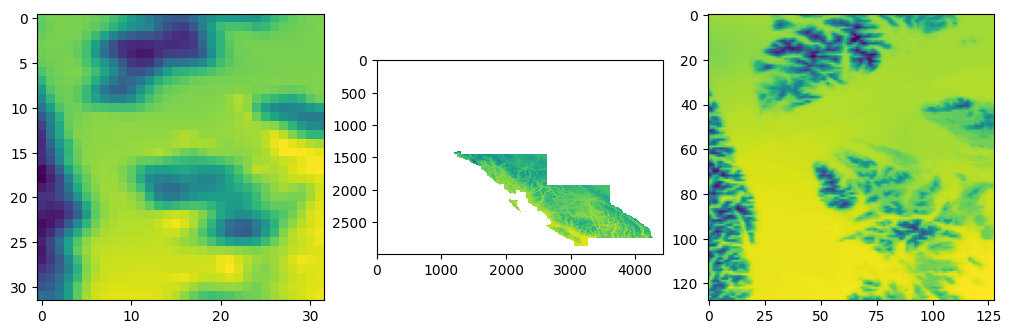

In [44]:
i = 1988

fig, ax = plt.subplots(1, 3, layout='constrained', figsize=(10, 7))

pc1 = ax[0].imshow(good_tiles_wrf[i])

pc1 = ax[1].imshow(prism_pt)
pc3 = ax[2].imshow(good_tiles_prism[i])

In [25]:
size_fine = 128*128
good_tiles_prism_test = []
good_tiles_dem_test = []
good_tiles_coast_test = []
good_tiles_lat_test = []
good_tiles_lon_test = []

good_tiles_wrf_test = []
good_tiles_worldclim_test = []

for i in range(0, len(tiles_fine_prism_test)):
    ind = np.argwhere(np.isnan(tiles_fine_prism_test[i]))
    percent_nan_prism = ind.shape[0]/size_fine *100
    ind = np.argwhere(np.isnan(tiles_coarse_wrf_test[i]))
    percent_nan_wrf = ind.shape[0]/size_coarse *100
    if ((percent_nan_prism == 0) & (percent_nan_wrf==0)):
        good_tiles_prism_test.append(tiles_fine_prism_test[i])
        good_tiles_dem_test.append(tiles_fine_dem_test[i])
        good_tiles_coast_test.append(tiles_fine_coast_test[i])
        good_tiles_lat_test.append(tiles_fine_lat_test[i])
        good_tiles_lon_test.append(tiles_fine_lon_test[i])
        
        good_tiles_wrf_test.append(tiles_coarse_wrf_test[i])
        good_tiles_worldclim_test.append(tiles_coarse_worldclim_test[i])
        
    elif ((percent_nan_prism <= 25) & (percent_nan_wrf <= 25)):
        
        good_tiles_prism_test.append(np.nan_to_num(tiles_fine_prism_test[i], nan=np.nanmean(tiles_fine_prism_test[i])))
        
        good_tiles_wrf_test.append(np.nan_to_num(tiles_coarse_wrf_test[i], nan=np.nanmean(tiles_coarse_wrf_test[i])))
        
        good_tiles_worldclim_test.append(np.nan_to_num(tiles_coarse_worldclim_test[i], nan=np.nanmean(tiles_coarse_worldclim_test[i])))
        
        good_tiles_dem_test.append(np.nan_to_num(tiles_fine_dem_test[i], nan=np.nanmean(tiles_fine_dem_test[i])))
        good_tiles_coast_test.append(np.nan_to_num(tiles_fine_coast_test[i], nan=np.nanmean(tiles_fine_coast_test[i])))
        good_tiles_lat_test.append(np.nan_to_num(tiles_fine_lat_test[i], nan=np.nanmean(tiles_fine_lat_test[i])))
        good_tiles_lon_test.append(np.nan_to_num(tiles_fine_lon_test[i], nan=np.nanmean(tiles_fine_lon_test[i])))

In [26]:
tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_prism))]
good_tiles_prism = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)
for i in range(0,len(good_tiles_prism)):
    filename = '/home/sbeale/tmax_march_pt_BC/train/hr/prism_' + str(i) + '.pt'
    torch.save(good_tiles_prism[i], filename)

del(good_tiles_prism)
del(tiles_unsq)

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf))]
good_tiles_wrf = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)
for i in range(0,len(good_tiles_prism)):
    filename = '/home/sbeale/tmax_march_pt_BC/train/lr/wrf_' + str(i) + '.pt'
    torch.save(good_tiles_wrf[i], filename)

del(good_tiles_wrf)
del(tiles_unsq)

# tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_worldclim))]
# good_tiles_worldclim = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)
# for i in range(0,len(good_tiles_prism)):
#     filename = '/home/sbeale/tmax_march_pt_BC/train/lr/world_clim_' + str(i) + '.pt'
#     torch.save(good_tiles_worldclim[i], filename)

# del(good_tiles_worldclim)
# del(tiles_unsq)

KeyboardInterrupt: 

In [27]:
tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_prism_test))]
good_tiles_prism_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)
for i in range(0,len(good_tiles_prism_test)):
    filename = '/home/sbeale/tmax_march_pt_BC/test/hr/prism_' + str(i) + '.pt'
    torch.save(good_tiles_prism_test[i], filename)

del(good_tiles_prism_test)
del(tiles_unsq)

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf_test))]
good_tiles_wrf_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)
for i in range(0,len(good_tiles_prism)):
    filename = '/home/sbeale/tmax_march_pt_BC/test/lr/wrf_' + str(i) + '.pt'
    torch.save(good_tiles_wrf_test[i], filename)

del(good_tiles_wrf_test)
del(tiles_unsq)

# tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_worldclim_test))]
# good_tiles_worldclim_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)
# torch.save(good_tiles_worldclim_test, '/home/sbeale/tmax_march_pt_BC/worldclim_test.pt')

# del(good_tiles_worldclim_test)
# del(tiles_unsq)

In [29]:
for i in range(0,len(good_tiles_prism)):
    filename = '/home/sbeale/tmax_march_pt_BC/train/prism_' + str(i) + '.pt'
    print(filename)

/home/sbeale/tmax_march_pt_BC/train/prism_0.pt
/home/sbeale/tmax_march_pt_BC/train/prism_1.pt
/home/sbeale/tmax_march_pt_BC/train/prism_2.pt
/home/sbeale/tmax_march_pt_BC/train/prism_3.pt
/home/sbeale/tmax_march_pt_BC/train/prism_4.pt
/home/sbeale/tmax_march_pt_BC/train/prism_5.pt
/home/sbeale/tmax_march_pt_BC/train/prism_6.pt
/home/sbeale/tmax_march_pt_BC/train/prism_7.pt
/home/sbeale/tmax_march_pt_BC/train/prism_8.pt
/home/sbeale/tmax_march_pt_BC/train/prism_9.pt
/home/sbeale/tmax_march_pt_BC/train/prism_10.pt
/home/sbeale/tmax_march_pt_BC/train/prism_11.pt
/home/sbeale/tmax_march_pt_BC/train/prism_12.pt
/home/sbeale/tmax_march_pt_BC/train/prism_13.pt
/home/sbeale/tmax_march_pt_BC/train/prism_14.pt
/home/sbeale/tmax_march_pt_BC/train/prism_15.pt
/home/sbeale/tmax_march_pt_BC/train/prism_16.pt
/home/sbeale/tmax_march_pt_BC/train/prism_17.pt
/home/sbeale/tmax_march_pt_BC/train/prism_18.pt
/home/sbeale/tmax_march_pt_BC/train/prism_19.pt
/home/sbeale/tmax_march_pt_BC/train/prism_20.pt
/h

In [28]:
good_tiles_lon[0].shape

(128, 128)

In [29]:
tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_dem))]
good_tiles_dem = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del(tiles_unsq)

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_coast))]
good_tiles_coast = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del(tiles_unsq)

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_lat))]
good_tiles_lat = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del(tiles_unsq)

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_lon))]
good_tiles_lon = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)


del(tiles_unsq)

In [30]:
good_tiles_lon.shape

torch.Size([43348, 1, 128, 128])

In [31]:
x = torch.cat((good_tiles_dem, good_tiles_lat, good_tiles_lon, good_tiles_coast), dim=1)
x.shape

torch.Size([43348, 4, 128, 128])

In [32]:
torch.save(x, '/home/sbeale/tmax_march_pt_BC/HR_covariates_train.pt')

del(x)
del(good_tiles_dem)
del(good_tiles_lat)
del(good_tiles_lon)
del(good_tiles_coast)

In [33]:
tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_dem_test))]
good_tiles_dem_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del(tiles_unsq)

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_coast_test))]
good_tiles_coast_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del(tiles_unsq)

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_lat_test))]
good_tiles_lat_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del(tiles_unsq)

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_lon_test))]
good_tiles_lon_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)


del(tiles_unsq)

In [46]:
x = torch.cat((good_tiles_dem_test, good_tiles_lat_test, good_tiles_lon_test, good_tiles_coast_test), dim=1)
x.shape

NameError: name 'good_tiles_dem_test' is not defined

In [35]:
torch.save(x, '/home/sbeale/tmax_march_pt_BC/HR_covariates_test.pt')

del(x)
del(good_tiles_dem_test)
del(good_tiles_lat_test)
del(good_tiles_lon_test)
del(good_tiles_coast_test)

In [36]:
# size_fine = 128*128
# good_tiles_fine = []
# good_tiles_coarse = []
# for i in range(0, len(tiles_fine)):
#     ind = np.argwhere(np.isnan(tiles_fine[i]))
#     percent_nan = ind.shape[1]/size_fine *100
#     if (percent_nan == 0):
#         good_tiles_fine.append(tiles_fine[i])
#         good_tiles_coarse.append(tiles_coarse[i])
#     if (percent_nan <= 25):
#         mean_fine = np.nanmean(tiles_fine[i])
#         for i in range(0, ind.shape[1]):
#             x = ind[...,i][0]
#             y = ind[...,i][1]
#             tiles_fine[i,x,y] = mean_fine.astype('float64')
#         good_tiles_fine.append(tiles_fine[i])
        
#         mean_coarse = np.nanmean(tiles_coarse[i])
#         ind_coarse = np.argwhere(np.isnan(tiles_coarse[i]))
#         for i in range(0, ind_coarse.shape[1]):
#             x = ind_coarse[...,i][0]
#             y = ind_coarse[...,i][1]
#             tiles_coarse[i,x,y] = mean_coarse.astype('float64')
#         good_tiles_coarse.append(tiles_coarse[i])
        
            